Instalacion de Liberias

In [ ]:
!pip install fastai -Uqq
!pip install datasets -Uqq
import pandas as pd
from fastai.text.all import *
from datasets import load_dataset

     |████████████████████████████████| 197 kB 5.1 MB/s 
     |████████████████████████████████| 60 kB 7.8 MB/s 
     |████████████████████████████████| 361 kB 5.4 MB/s 
     |████████████████████████████████| 140 kB 63.2 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 212 kB 47.6 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 596 kB 56.8 MB/s 
     |████████████████████████████████| 127 kB 67.9 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 144 kB 57.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


El dataset que he elegido es el de rotten tomatoes

Procedo a descargarlo, cargar los datos, y ponerlo en un formato más legible

In [ ]:
rotten_tomatoes_dataset = load_dataset("rotten_tomatoes")

Using custom data configuration default


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_df = rotten_tomatoes_dataset["train"].to_pandas()
valid_df = rotten_tomatoes_dataset["validation"].to_pandas()
test_df = rotten_tomatoes_dataset["test"].to_pandas()

In [ ]:
train_df['set']=False
valid_df['set']=True
train_valid_df = pd.concat([train_df,valid_df])
train_valid_df = train_valid_df.rename(columns={"verse_text": "text"})

Creamos el DataBlock y el DataLoader, y hacemos una pequeña prueba de como el programa trata las frases

In [ ]:
db_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True,max_vocab=100000), 
    get_items=ColReader('text'), splitter=RandomSplitter(0.1))

In [ ]:
dls_lm = db_lm.dataloaders(train_valid_df, bs=128, seq_len=80)

In [ ]:
dls_lm.show_batch(max_n=6)

,text,text_
0,"xxbos gooding and xxunk are both oscar winners , a fact which , as you watch them clumsily mugging their way through snow dogs , seems xxunk . xxbos the somber pacing and lack of dramatic xxunk make green dragon seem more like medicine than entertainment . xxbos an eloquent , reflective and beautifully acted meditation on both the profoundly devastating events of one year ago and the slow , painful healing process that has followed in their wake .","gooding and xxunk are both oscar winners , a fact which , as you watch them clumsily mugging their way through snow dogs , seems xxunk . xxbos the somber pacing and lack of dramatic xxunk make green dragon seem more like medicine than entertainment . xxbos an eloquent , reflective and beautifully acted meditation on both the profoundly devastating events of one year ago and the slow , painful healing process that has followed in their wake . xxbos"
1,"about knockaround guys is its lame xxunk for xxunk the xxunk xxunk when in fact the film is n't as xxunk or slick as it thinks it is . xxbos if you 're content with a clever pseudo - bio that manages to have a good time as it xxunk out pieces of the famous director 's life , eisenstein delivers . xxbos what a xxunk brilliant and entertaining movie this is . xxbos strong setup and ambitious goals fade","knockaround guys is its lame xxunk for xxunk the xxunk xxunk when in fact the film is n't as xxunk or slick as it thinks it is . xxbos if you 're content with a clever pseudo - bio that manages to have a good time as it xxunk out pieces of the famous director 's life , eisenstein delivers . xxbos what a xxunk brilliant and entertaining movie this is . xxbos strong setup and ambitious goals fade as"
2,". xxbos this rough xxunk punch - and - xxunk act did n't play well then and it plays worse now . xxbos xxunk are the terrific performances by christopher plummer , as the prime villain , and xxunk lane as vincent xxunk , the eccentric theater company xxunk . xxbos ' unfaithful ' xxunk on itself and xxunk to comfortable territory . too bad . xxbos it strikes xxunk when it reminds you how pertinent its dynamics remain","xxbos this rough xxunk punch - and - xxunk act did n't play well then and it plays worse now . xxbos xxunk are the terrific performances by christopher plummer , as the prime villain , and xxunk lane as vincent xxunk , the eccentric theater company xxunk . xxbos ' unfaithful ' xxunk on itself and xxunk to comfortable territory . too bad . xxbos it strikes xxunk when it reminds you how pertinent its dynamics remain ."
3,"have fun xxunk a brand - new pokemon called xxunk . xxbos almost everyone growing up believes their family must look like "" the xxunk family "" to everyone looking in . . . "" my big fat greek wedding "" comes from the heart . . . xxbos the movie has lots of dancing and xxunk music . there are slow and repetitive parts , but it has just enough spice to keep it interesting . xxbos a moving","fun xxunk a brand - new pokemon called xxunk . xxbos almost everyone growing up believes their family must look like "" the xxunk family "" to everyone looking in . . . "" my big fat greek wedding "" comes from the heart . . . xxbos the movie has lots of dancing and xxunk music . there are slow and repetitive parts , but it has just enough spice to keep it interesting . xxbos a moving story"
4,". xxbos a quiet , pure , xxunk film xxbos it 's a hoot watching the rock chomp on xxunk xxunk , pull an xxunk out of his back , and xxunk xxunk through xxunk fire ! xxbos an earnest , xxunk document , it serves as a xxunk xxunk for the xxunk 's recent history , and would make a terrific xxunk - grade learning tool . xxbos is it a comedy ? a drama ? a romance ?","xxbos a quiet , pure , xxunk film xxbos it 's a hoot watching the rock chomp on xxunk xxunk , pull an xxunk out of his back , and xxunk xxunk through xxunk fire ! xxbos an earnest , xxunk document , it serves as a xxunk xxunk for the xxunk 's recent history , 

Ahora creamos un Learner y lo entrenamos. Asimismo guardamos el encoder

In [ ]:
learn = language_model_learner(dls_lm,AWD_LSTM,drop_mult=0.3,metrics=[accuracy, Perplexity()] ).to_fp16()

In [ ]:
learn.fine_tune(10,base_lr=2e-2)
learn.save_encoder('finetuned')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.128624,4.269804,0.249917,71.507652,00:14


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.146022,4.071663,0.289233,58.654446,00:14
1,4.028412,3.994905,0.299013,54.320667,00:14
2,3.897111,3.977654,0.300358,53.391617,00:13
3,3.728782,4.013168,0.301490,55.321873,00:13
4,3.528436,4.120527,0.289360,61.591709,00:14
5,3.335266,4.200895,0.292400,66.746063,00:13
6,3.119284,4.276430,0.287455,71.982979,00:14
7,2.917953,4.364005,0.284102,78.571152,00:13
8,2.740832,4.400688,0.282895,81.506905,00:13
9,2.610602,4.406274,0.282044,81.963524,00:14


En el siguiente paso traduciremos nuestro dataframe en un datablock para poder definir un dataloader sobre el

In [ ]:
sentiment_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),
            CategoryBlock), 
    get_x=ColReader('text'), 
    get_y=ColReader('label'),
    splitter=ColSplitter('set')
)

In [ ]:
dls = sentiment_clas.dataloaders(train_valid_df, bs=64)
dls.show_batch(max_n=6)

,text,category
0,"xxbos who are ' they ' ? well , they 're ' they ' . they 're the xxunk , easily xxunk forces that serve as whatever terror the heroes of horror movies try to avoid . they exist for xxunk lines like "" they 're back ! "" , "" they 're out there ! "" and "" they 're coming ! """,0
1,"xxbos the film is faithful to what one xxunk are the book 's twin xxunk -- that we become who we are on the xxunk of our parents , but we have no idea who they were at our age ; and that time is a fleeting and precious xxunk no matter how old you are .",1
2,"xxbos [ city ] reminds us how xxunk nuanced a robert de niro performance can be when he is not more xxunk engaged in the shameless self - xxunk of ' analyze this ' ( 1 xxrep 3 9 ) and ' analyze that , ' xxunk ( or xxunk ) for later this year .",1
3,"xxbos the film has a few cute ideas and several modest chuckles but it is n't exactly kiddie - friendly xxunk alas , santa is more ho - xxunk than ho - ho - ho and the xxunk ( who never gets to play that xxunk ) has all the charm of a xxunk .",0
4,"xxbos "" red dragon "" is entertaining . an obvious copy of one of the best films ever made , how could it not be ? but it is entertaining on an xxunk level . it is a popcorn film , not a must - own , or even a must - see .",1
5,"xxbos it cuts to the core of what it actually means to face your fears , to be a girl in a world of boys , to be a boy truly in love with a girl , and to ride the big metaphorical wave that is life -- xxunk it takes you .",1


Creamos ahora un learner mas complejo como es un text_classifier_learner

In [ ]:
callbacks = [ShowGraphCallback(),
             SaveModelCallback()]

learnClass = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy,cbs=callbacks).to_fp16()

Cargamos el encoder, y aplicamos fine-tuning

epoch,train_loss,valid_loss,accuracy,time
0,0.567538,0.509648,0.754221,00:11


Better model found at epoch 0 with valid_loss value: 0.5096479654312134.


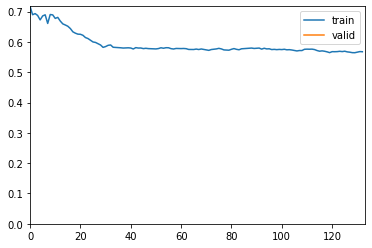

epoch,train_loss,valid_loss,accuracy,time
0,0.475464,0.415085,0.819887,00:12
1,0.432906,0.528906,0.766416,00:12
2,0.378127,0.429130,0.803940,00:12
3,0.298179,0.406795,0.821764,00:12
4,0.213191,0.496888,0.800188,00:12
5,0.147690,0.589155,0.803002,00:12
6,0.087080,0.694366,0.825516,00:12
7,0.055756,0.742422,0.827392,00:12
8,0.038787,0.809631,0.821764,00:12
9,0.027747,0.819289,0.819887,00:13


Better model found at epoch 0 with valid_loss value: 0.4150846302509308.


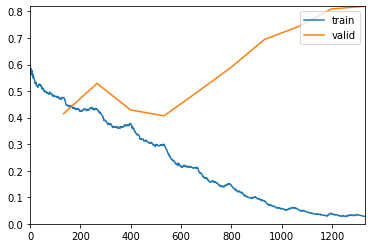

Better model found at epoch 3 with valid_loss value: 0.40679529309272766.


In [ ]:
learnClass = learnClass.load_encoder('finetuned')
learnClass.fine_tune(10, 6e-2)

Probamos varias clases sobre el modelo

In [ ]:
learnClass.predict('this movie is for people with really bad taste')

('0', TensorText(0), TensorText([0.8837, 0.1163]))

In [ ]:
learnClass.predict('my daughter was laughing a lot during the movie')

('0', TensorText(0), TensorText([0.5077, 0.4923]))

In [ ]:
learnClass.predict('my daughter liked the ending scenes a lot')

('1', TensorText(1), TensorText([0.3457, 0.6543]))

El texto generalmente da bastantes falsos negativos, para encontrar positivos hemos de ser algo literales con palabras como good, like o happy

Por último, aplicamos sobre el conjunto de tests

In [ ]:
test_df['set']=True
train_test_df = pd.concat([train_df,test_df])
train_test_df = train_test_df.rename(columns={"verse_text": "text"})
dls_test = sentiment_clas.dataloaders(train_test_df, bs=64)

In [ ]:
learnClass.dls = dls_test
learnClass.validate()

Better model found at epoch 0 with valid_loss value: 0.8142589330673218.


(#2) [0.4335748255252838,0.8142589330673218]